In [32]:
import numpy as np
import sys
import imageio
sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
sys.path.insert(1,'/home/zhanibek/catkin_ws/src/smart_tray/scripts/')
import cv2 
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from PIL import Image

import pickle
import pandas as pd
from phri.utils import *

In [16]:
sys.version

'2.7.12 (default, Oct  8 2019, 14:14:10) \n[GCC 5.4.0 20160609]'

### Constants

In [139]:
meta_data_paths = [
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_sanket/trial_0/koh_sanket_trial_0_2020-10-11-20-48-27_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/koh_zhanibek_trial_0_2020-10-11-21-19-07_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_0/trial_0_2020-10-12-14-47-43_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_1/trial_1_2020-10-12-14-51-53_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_sanket/trial_0/trial_0_2020-10-12-15-02-32_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_vignesh/trial_0/trial_0_2020-10-12-14-57-11_meta_data_v2.pkl'
]

ann_paths = ['/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - KOH_Sanket.csv',
             '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - KOH_Zhanibek.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Sanket_Vignesh_1.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Sanket_Vignesh_2.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Zhanibek_Sanket.csv',
            '/home/zhanibek/codes/phhi_data_analysis/data/annotation/annotation - Zhanibek_Vignesh.csv']

imu_delay_const = 52345.383253
imu_delays = np.array([0,0,0,0,0,0])
imu_delays[[2,3,4,5]] = imu_delay_const


ipath = 0

meta_data_path = meta_data_paths[ipath]
# ft_data_path = ft_data_paths[ipath]
ann_path = ann_paths[ipath]
trial_pair = os.path.basename(ann_path).split('- ')[-1].split('.')[0]
imu_delay = imu_delays[ipath]

In [140]:
meta_data = pickle.load(open(meta_data_path))

In [141]:
meta_data.keys()

['camera_3_raw_pose_offline',
 'camera_3',
 '/cam1_tray_pose_estimation',
 'camera_3_grf_offline',
 'camera_2_raw_pose_offline',
 'camera_1_raw_pose_offline',
 'summary',
 'camera_1_grf_offline',
 '/cam2_tray_pose_estimation',
 '/cam3_tray_pose_estimation',
 '/cam1_tray_grf',
 '/cam2_tray_grf',
 'camera_2_grf_offline',
 'camera_1',
 'camera_2',
 '/RFT_FORCE',
 '/imu_data',
 '/RFT_FORCE_2',
 '/cam3_tray_grf']

### Summary

In [142]:
summary = meta_data['summary']
cam1_df = meta_data['camera_1']
cam2_df = meta_data['camera_2']
cam3_df = meta_data['camera_3']

rft1_df = meta_data['/RFT_FORCE']
rft2_df = meta_data['/RFT_FORCE_2']

imu_df = meta_data['/imu_data']

pose1_df = meta_data['/cam1_tray_pose_estimation']
pose2_df = meta_data['/cam2_tray_pose_estimation']
pose3_df = meta_data['/cam3_tray_pose_estimation']

grf1_df = meta_data['/cam1_tray_grf']
grf2_df = meta_data['/cam2_tray_grf']
grf3_df = meta_data['/cam3_tray_grf']


In [143]:
summary

,topic_name,message_count,frequency,msg_type,start_time,end_time
0,/cam1_tray_pose_estimation,5790,20.014525,geometry_msgs/PoseStamped,1.602467e+09,1.602468e+09
1,/cam2_tray_grf,3858,30.558701,geometry_msgs/PoseStamped,1.602467e+09,1.602468e+09
2,/cam2_tray_pose_estimation,8908,30.654739,geometry_msgs/PoseStamped,1.602467e+09,1.602468e+09
3,/cam3_tray_pose_estimation,8910,29.983944,geometry_msgs/PoseStamped,1.602467e+09,1.602468e+09
4,/cam1_tray_grf,3678,19.198096,geometry_msgs/PoseStamped,1.602467e+09,1.602468e+09
5,/RFT_FORCE_2,251144,1005.105200,geometry_msgs/WrenchStamped,1.602467e+09,1.602468e+09
6,/RFT_FORCE,250060,1005.587149,geometry_msgs/WrenchStamped,1.602467e+09,1.602468e+09
7,/imu_data,22964,77.253127,smart_tray/imu_msg,1.602467e+09,1.602468e+09
8,/cam3_tray_grf,3801,29.804438,geometry_msgs/PoseStamped,1.602467e+09,1.602468e+09


In [144]:
meta_data['camera_1_raw_pose_offline'].keys()

Index([u'seq', u'time_stamp', u'frame_id', u'position', u'quaternion'], dtype='object')

### Annotations

In [145]:
ann_df0 = pd.read_csv(ann_path)
ann_df0.columns = ['obs_num', 'trajectory_type', 'motion_type', 'negotiation', 't0_cam_1_seq',
                  't0_sec', 'tf_cam_1_seq', 'tf_sec', 'duration', 't0_precise','tf_precise',
                  'duration_precise']

time_offset = float(ann_df0['t0_sec'][0])*1000
time_offset

1602467000.0

In [146]:
ann_df = ann_df0[5:]
ann_df

,obs_num,trajectory_type,motion_type,negotiation,t0_cam_1_seq,t0_sec,tf_cam_1_seq,tf_sec,duration,t0_precise,tf_precise,duration_precise
5,1.0,AB1,parallel,NaN,17475,1602467318,17920,1602467330,12,319.3629,330.0816,10.7187
6,2.0,BA2,serial,NaN,18006,1602467332,18401,1602467341,9,332.2502,341.82,9.5698
7,3.0,AB1,serial,NaN,18487,343,18967,356,13,344.1228,356.6791,12.5563
8,4.0,BA1,parallel,NaN,19077,359,19520,372,13,359.1155,372.8226,13.7071
9,5.0,AB2,parallel,NaN,20655,402,21000,413,11,402.7888,411.8186,9.0298
10,6.0,BA1,parallel,NaN,21010,413,21427,424,11,414.3004,424.2445,9.9441
11,7.0,AB2,parallel,NaN,21517,427,21945,439,12,427.3242,437.8941,10.5699
12,8.0,BA2,serial,NaN,22016,440,22349,449,9,440.5338,449.8343,9.3005
13,9.0,AB2,parallel,NaN,22476,453,22820,463,10,452.9302,463.0416,10.1114
14,10.0,BA2,parallel,NaN,23287,476,23654,486,10,477.0748,486.4523,9.3775


## Functions

In [147]:
def create_gif(tt0, ttf, temp_df, obs):
    
    base_path = '/home/zhanibek/codes/phhi_data_analysis/data/gifs'
    
    if 'angetube' in temp_df.frame_id[0]:
        cam_id = 'camera_1'
    elif 'logitech_t1' in temp_df.frame_id[0]:
        cam_id = 'camera_2'
    elif 'logitech_t2' in temp_df.frame_id[0]:
        cam_id = 'camera_3'
    
    cut = temp_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = temp_df[cut]
    
    gifname = obs['obs_id'] + '_' + obs['traj_type'] + '_' + obs['motion_type'] + '.gif'
    gifpath = os.path.join(base_path, cam_id, gifname)

    N = temp.shape[0];
    images = []
    for ind in range(N):

        impath = temp.image_path.iloc[ind]

        imname_aruco = os.path.basename(impath).split('.')[0]+'_aruco_offline.jpg'
        impath_aruco = os.path.join(os.path.split(impath)[0]+'_aruco_offline',imname_aruco) 
        
        if os.path.exists(impath_aruco):
            im = Image.open(impath_aruco)
#             if cam_id not in 'camera_3':
            (width, height) = (im.width // 4, im.height // 4)
#             else:
#                 (width, height) = (im.width, im.height)
                
            im_resized = im.resize((width, height), resample = Image.LANCZOS)
            images.append(im_resized)
    
    images[0].save(gifpath, format='GIF', append_images=images[1:],
                    save_all=True, duration=100/3, loop=0, optimize=True);
        

        
        
    

### Get Observations

In [148]:
total_obs = ann_df.shape[0]
observations = []

camera_1 = meta_data['camera_1']
camera_2 = meta_data['camera_2']
camera_3 = meta_data['camera_3']

for obs_num in tqdm(range(1,total_obs+1)):

    tt0 = float(ann_df.t0_precise[ann_df.obs_num==obs_num])+time_offset - 1.0
    ttf = float(ann_df.tf_precise[ann_df.obs_num==obs_num])+time_offset + 1.0
    
    traj_type = ann_df.trajectory_type[ann_df.obs_num==obs_num].iloc[0]
    motion_type = ann_df.motion_type[ann_df.obs_num==obs_num].iloc[0]
    
    obs = {'traj_type':traj_type, 'motion_type': motion_type, 'obs_id':trial_pair+'_'+str(obs_num)}    
    
    create_gif(tt0, ttf, camera_1, obs)
    create_gif(tt0, ttf, camera_2, obs)
    create_gif(tt0, ttf, camera_3, obs)
    
    observations.append(obs)

### Camera 1

/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/camera_1/images/angetube_99284_99285_1602469409_620487928.png


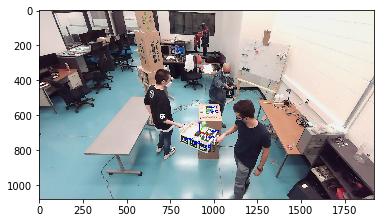

In [72]:
camera_1 = meta_data['camera_1']

impath = camera_1.image_path[2100]

imname_aruco = os.path.basename(impath).split('.')[0]+'_aruco_offline.jpg'
impath_aruco = os.path.join(os.path.split(impath)[0]+'_aruco_offline',imname_aruco) 

im = read_image(impath_aruco)
plt.imshow(im)
print impath

### Draft

In [73]:
obs_num = 2
tt0 = float(ann_df.t0_precise[ann_df.obs_num==obs_num])+time_offset - 1.0
ttf = float(ann_df.tf_precise[ann_df.obs_num==obs_num])+time_offset + 1.0

cut = camera_1.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
temp = camera_1[cut]

# gifname = obs.obs_id, '_', obs.traj_type, '_', obs.motion_type

In [74]:
temp

,seq,time_stamp,frame_id,image_path
517,92826,1.602469e+09,angetube_92825,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
518,92827,1.602469e+09,angetube_92826,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
519,92828,1.602469e+09,angetube_92827,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
520,92829,1.602469e+09,angetube_92828,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
521,92830,1.602469e+09,angetube_92829,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
522,92831,1.602469e+09,angetube_92830,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
523,92832,1.602469e+09,angetube_92831,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
524,92833,1.602469e+09,angetube_92832,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
525,92859,1.602469e+09,angetube_92858,/home/zhanibek/catkin_ws/src/smart_tray/data/r...
526,92860,1.602469e+09,angetube_92859,/home/zhanibek/catkin_ws/src/smart_tray/data/r...


In [ ]:
temp.image_path.iloc[0], temp.seq.iloc[0]

In [ ]:
traj_type = ann_df.trajectory_type[ann_df.obs_num==obs_num].iloc[0]
traj_type

In [ ]:
'logitech_t2' in camera_3.frame_id[0]

In [ ]:
camera_1.frame_id[0]

### Mix Plot

In [ ]:
plt.figure(figsize=(20,8))

plt.plot(imu_t_vec, accel_z)
plt.plot(rft1_t_vec, force1_y)
plt.plot(rft2_t_vec, force2_y)
plt.plot(grf1_t_vec, grf1_x)
plt.plot(grf2_t_vec, grf2_x)
plt.plot(grf3_t_vec, grf3_x)
plt.grid()
plt.legend(['accel_z', 'force1_y', 'force2_y', 'grf1_z', 'grf2_z', 'grf3_z'])
plt.title('Mix Plot')
plt.xlabel('time, sec')